# Exploring results from DC power flow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

import json
import os

from collections import defaultdict

In [2]:
data_dir = '~/research/ream-lab/CATS-CaliforniaTestSystem'

with open('pf_solution.json') as f:
    soln = json.load(f)
    print(soln['termination_status'])

LOCALLY_SOLVED


In [3]:
generators = pd.read_csv(os.path.join(data_dir, 'GIS', 'CATS_gens.csv'))
generators['id'] = generators.index + 1
generators

,PlantCode,GenID,bus,FuelType,Pg,Pmax,Pmin,Qg,Qmax,Qmin,Lat,Lon,id
0,34,1P,745,Conventional Hydroelectric,4.033363,12.1,0,0,18.777143,-14.670714,39.134259,-120.953341,1
1,151,1,1804,Petroleum Liquids,0.000000,71.2,0,0,34.500000,-23.700000,37.629360,-120.931390,2
2,151,2,1804,Natural Gas Fired Combustion Turbine,0.000000,71.2,0,0,34.500000,-23.700000,37.629360,-120.931390,3
3,161,1,1964,Conventional Hydroelectric,0.366669,1.1,0,0,18.777143,-14.670714,37.611461,-120.594678,4
4,161,2,1964,Conventional Hydroelectric,0.366669,1.1,0,0,18.777143,-14.670714,37.611461,-120.594678,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887,0,0,8862,Synchronous Condenser,0.000000,0.0,0,0,200.000000,-200.000000,32.696514,-117.143455,3888
3888,0,0,8863,Synchronous Condenser,0.000000,0.0,0,0,200.000000,-200.000000,34.366663,-117.368629,3889
3889,0,0,8864,Synchronous Condenser,0.000000,0.0,0,0,200.000000,-200.000000,34.366600,-117.368612,3890
3890,0,0,8865,Synchronous Condenser,0.000000,0.0,0,0,200.000000,-200.000000,35.841706,-119.085033,3891


In [4]:
# Load California county boundaries shapefile
# Shapefile source https://gis.data.ca.gov/datasets/8713ced9b78a4abb97dc130a691a8695
county_shapes = gpd.read_file(os.path.join(data_dir, 'GIS', 'california_county_boundaries', 'cnty19_1.shp'))
county_shapes = county_shapes.to_crs("EPSG:4326")

# Create a GeoDataFrame from the generators DataFrame
generators_geo = gpd.GeoDataFrame(
    generators,
    geometry=gpd.points_from_xy(generators['Lon'], generators['Lat'], crs="EPSG:4326")
)

# Perform spatial join to get county information for each generator
joined_data = gpd.sjoin(generators_geo, county_shapes, how="left", predicate="within")

# Create a dictionary mapping PlantCode to county name
generator_to_county = dict(zip(joined_data['id'], joined_data['COUNTY_NAM']))

# Use the resulting dictionary
# Print top 5 dictionary entries for now
gen_to_county_slice = dict(list(generator_to_county.items())[0: 5])
print(str(gen_to_county_slice))


{1: 'Placer', 2: 'Stanislaus', 3: 'Stanislaus', 4: 'Stanislaus', 5: 'Stanislaus'}


Now we have a dictionary of generators to county. Next we iterate through the solution to assign each generator to a county, which allows us to aggregate generation mix at the county level.

In [5]:
# Create a dict mapping county to generation mix
county_mix = defaultdict(list)

for g in soln['solution']['gen']:
    county = generator_to_county[int(g)]
    county_mix[county].append((int(g), soln['solution']['gen'][g]["pg"]))

county_mix

defaultdict(list,
            {'Los Angeles': [(2243, 0.0),
              (599, 0.1358427574422536),
              (228, -9.609564847572121e-09),
              (3697, 0.0),
              (1429, -9.963693026758635e-09),
              (1665, 0.02327260121885969),
              (598, 0.1358427574422536),
              (3213, 0.0),
              (613, 0.012000009551842574),
              (3324, 0.0),
              (2288, 0.0),
              (2096, 0.020000009081675808),
              (3615, 0.0),
              (2276, 0.0),
              (2752, 0.0),
              (1882, 0.025858444716800533),
              (3652, 0.0),
              (1468, 0.04525227081857709),
              (3510, 0.0),
              (1220, -9.669855867953912e-09),
              (1969, 0.025858444695879664),
              (3170, 0.0),
              (3280, 0.0),
              (611, 0.10108266107253647),
              (1836, 0.038787662095879666),
              (2220, 0.0),
              (2312, 0.0),
              (474, 0.4

In [18]:
def gen_share_for_list(gen_list):
    grouped_gen_list = defaultdict(float)

    for gen, pg in gen_list:
        # Round very small numbers to 0
        if pg < 1e-6:
            pg = 0
            continue

        fuel_type = generators_geo.loc[generators_geo.id == gen].FuelType.iloc[0]
        grouped_gen_list[fuel_type] += pg

    total = sum(grouped_gen_list.values())

    if total == 0:
        return {}
    else:
        return {fuel: total_gen / total for fuel, total_gen in grouped_gen_list.items()}

county_gen_share = {county: gen_share_for_list(gen_list) for county, gen_list in county_mix.items()}

# Print or use county_gen_share
print(county_gen_share)


{'Los Angeles': {'Natural Gas Fired Combined Cycle': 0.41751531247796747, 'Solar Photovoltaic': 0.33656292297974527, 'Conventional Hydroelectric': 0.02757104544063788, 'Batteries': 0.00449816506054218, 'Onshore Wind Turbine': 0.0003176167781438328, 'Solar Thermal without Energy Storage': 0.0016210005215517677, 'Natural Gas Fired Combustion Turbine': 0.18040027716326196, 'All Other': 0.015051737180478109, 'Other Gases': 0.016094155298872287, 'Natural Gas Internal Combustion Engine': 0.00036776709879920245}, 'Kern': {'Solar Photovoltaic': 0.26811768268089475, 'Conventional Hydroelectric': 0.007955625888396914, 'Natural Gas Fired Combustion Turbine': 0.06197372778158181, 'Onshore Wind Turbine': 0.3768743950391061, 'Natural Gas Internal Combustion Engine': 0.0007449674140139046, 'Natural Gas Fired Combined Cycle': 0.2838371189709353, 'Batteries': 0.0004964822250713148}, 'San Diego': {'Solar Photovoltaic': 0.050111013989612166, 'Natural Gas Fired Combustion Turbine': 0.3734046624764026, 'Co

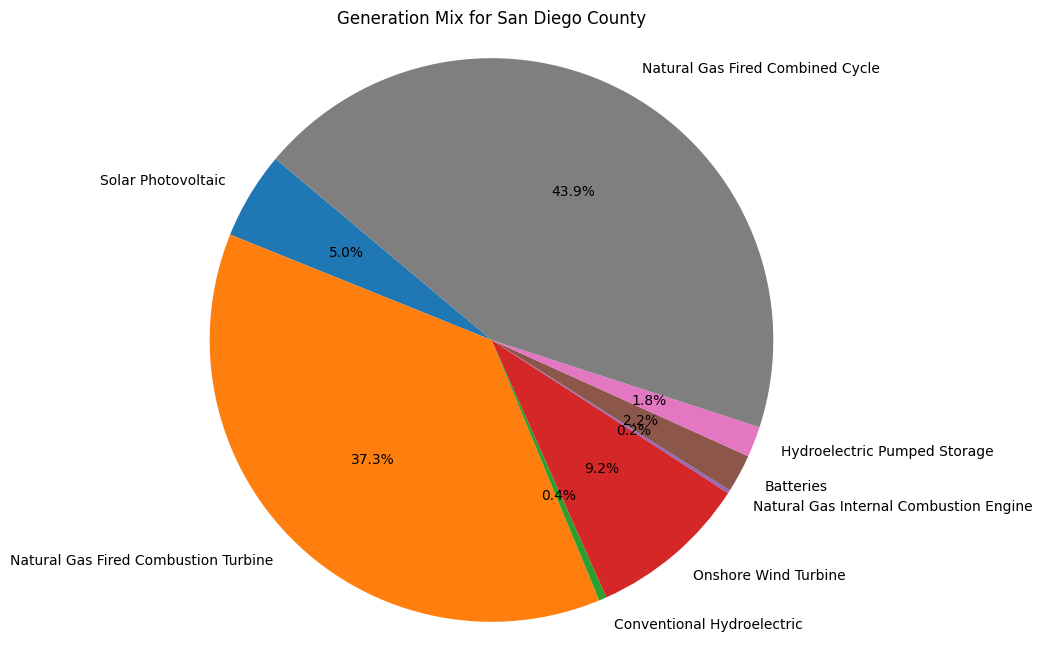

In [21]:
def plot_gen_mix_pie(county_name):
  # Get generation types and shares for the selected county
  gen_shares = gen_share_for_list(county_mix[county_name])
  gen_types = list(gen_shares.keys())
  gen_shares = list(gen_shares.values())

  # Create a pie chart
  plt.figure(figsize=(8, 8))
  plt.pie(gen_shares, labels=gen_types, autopct='%1.1f%%', startangle=140)
  plt.title(f"Generation Mix for {county_name} County")
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
  plt.show()

plot_gen_mix_pie('San Diego')
